### Installing and importing useful libraries

In [1]:
# Standard libraries
import os
import sys
import math
import random
import datetime

# Numerical computing
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_theme()

#importing optimization techniques
from implementations import *
from helpers import *

### Importing data

In [2]:

base_path = os.path.join("data", "dataset")

# File paths
x_train_path = os.path.join(base_path, "X_train_preprocessed.csv")
y_train_path = os.path.join(base_path, "y_train.csv")

# Load the data
x_train = np.loadtxt(x_train_path, delimiter=',', dtype=float, skiprows=1)
y_train = np.loadtxt(y_train_path, delimiter=',', dtype=float, skiprows=1, usecols=1)

# Convert y_train from {-1, 1} to {0, 1}
y_train = np.where(y_train == -1, 0, y_train)

# Print shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)



x_train shape: (328135, 439)
y_train shape: (328135,)


### Splitting the data between 20 % validation set and 80 % training set

In [3]:
def train_val_split(X, y, val_ratio=0.20, seed=42):
    '''
    Function to randomly split the data in a 20% validation set and a 80% training set
    Args : 
            - X (numpy array) dataset input
            - y (numpy array) dataset output
            - val_ratio (float) validation set percentage, default 20%
            - seed (int) random seed
    Returns : 
            - Input train set, input validation set, output train set, output validation set, train indices, validation indices
    '''
    X = np.asarray(X); y = np.asarray(y)
    n = X.shape[0]
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)

    n_val = int(np.round(n * val_ratio))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]

    return X[train_idx], X[val_idx], y[train_idx], y[val_idx], train_idx, val_idx


# split dataset in validation and train set
x_train_split, x_val_split, y_train_split, y_val_split, tr_idx, va_idx = train_val_split(x_train, y_train, val_ratio=0.20, seed=42)
print(x_train_split.shape)
print(x_val_split.shape)


(262508, 439)
(65627, 439)


### Hyperparameters definition and metrics

In [4]:
lambdas = [ 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]  # regularization parameters list
gammas = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1] # step-size parameters list
max_iters = [100] # max iters list
k_folds = 5


def compute_auc(y_true, y_scores):
    """
    AUC calculation using Mann-Whitney statistics
    Inputs : 
            - y_true : numpy array containing the real {0, 1} values of the dataset
            - y_scores : numpy array containing our predictions
    Output : 
            AUC Area under the ROC curve 
    """
    order = np.argsort(y_scores)
    y_true_sorted = y_true[order]

    n_pos = np.sum(y_true)
    n_neg = len(y_true) - n_pos

    # rank positions 
    rank_positions = np.arange(1, len(y_true_sorted) + 1)
    rank_sum = np.sum(rank_positions[y_true_sorted == 1])

    # AUC using Mann–Whitney
    auc = (rank_sum - n_pos*(n_pos+1)/2) / (n_pos * n_neg)
    return auc

def compute_accuracy(y_true, y_scores) : 
    """
    Accuracy computation
    Inputs : 
            - y_true : numpy array containing the real {0, 1} values of the dataset
            - y_scores : numpy array containing our predictions
    Output : 
            Accuracy = correct predictions / total predictions %

    """
    correct_pred = (y_true == y_scores)
    accuracy = np.mean(correct_pred) * 100
    return accuracy

def compute_F1(y_true, y_pred):
    # Convert to boolean arrays
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)

    # True positives, false positives, false negatives
    tp = np.sum(y_pred & y_true)
    fp = np.sum(y_pred & ~y_true)
    fn = np.sum(~y_pred & y_true)

    # F1 score
    return 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) > 0 else 0
    


### Functions to balance data

In [5]:
# BALANCING DATA BY UNDERSAMPLING

def undersample(y_train, seed=21):
    """Restituisce solo gli indici per un dataset bilanciato via undersampling."""
    rng = np.random.default_rng(seed)
    classes, counts = np.unique(y_train, return_counts=True)
    maj = classes[np.argmax(counts)]
    min_ = classes[np.argmin(counts)]

    maj_idx = np.flatnonzero(y_train == maj)
    min_idx = np.flatnonzero(y_train == min_)

    n = len(min_idx)
    sampled_maj = rng.choice(maj_idx, size=n, replace=False)
    balanced_idx = np.concatenate((sampled_maj, min_idx))
    rng.shuffle(balanced_idx)
    return balanced_idx

#BALANCING DATA BY OVERSAMPLING
def oversample(y_train, seed=21):
    """Function to implement balancing of the dataset using oversampling of the minority class
    Inputs : 
            - y_train : (numpy array) output train datatset
            - seed : (int) randomization seed
    """
    rng = np.random.default_rng(seed)
    classes, counts = np.unique(y_train, return_counts=True)
    maj_class = classes[np.argmax(counts)]
    min_class = classes[np.argmin(counts)]

    maj_idx = np.flatnonzero(y_train == maj_class)
    min_idx = np.flatnonzero(y_train == min_class)

    # sample minority indexes to be equal to the majority class
    sampled_min_idx = rng.choice(min_idx, size=len(maj_idx), replace=True)
    balanced_idx = np.concatenate((maj_idx, sampled_min_idx))
    rng.shuffle(balanced_idx)
    return balanced_idx


### K-fold cross validation with oversampling and undersampling dataset

In [6]:
import implementations
import importlib
importlib.reload(implementations)
from implementations import *

w_initial, _ = ridge_regression(y_train_split, x_train_split, lambda_=0.001) # to make the k-cross faster, we start by a better guess

def build_k_indices(N, k_fold, seed=21): 
    """build k indices for k-fold. 
        Args: N: num of samples 
              k_fold: K in K-fold, i.e. the fold num 
              seed: the random seed 
        Returns: 
              A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold 
    """
    num_row = N 
    interval = int(num_row / k_fold) 
    np.random.seed(seed) 
    indices = np.random.permutation(num_row) 
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)] 
    return np.array(k_indices)
     

def k_fold_cross_validation(y_train, x_train, lambdas, gammas, max_iters, k_fold, methods, w_initial, seed, undersampling = False, oversampling = True) :
    """
    Function to perform a k-cross validation between different models - L2-regularized logistic regression with gradient descent, 
    least squares, L2-regularized logistic regression with Adam, ridge regression, Linear regression with SGD and GD - in order to find the best one to make predictions on our dataset. We use AUC 
    as metric to rank the models

    Args : 
            - y_train (numpy array) output train dataset
            - x_train (numpy array) input train dataset
            - lambdas (list)  hyperparameters regularization term
            - gammas (list) step-sizes
            - max_iters (list) maximum iterations to perform in the optimization algorithm 
            - k_fold (int) number of folds to per perform k-cross
            - methods (list) methods to apply to reach the optimum parameters w_opt
            - seed (int) random seed
            - undersampling (boolean) k-cross will perform data balancing by undersampling the majority class or not 
            - oversampling (boolena)  k-cross will perform data balancing by oversampling the minority class or not 
    Returns:
            - results (list of dictionaries) contains for each method the best lambda, gamma, max_iter and their corresponding train loss, test loss , AUC, accuracy, predictions and optimum weights 
                        vector
            - best_overall (dictionary) contains the best method wrt AUC and its corresponding lambda, gamma, max_iter, train loss, test loss, AUC, accuracy, predictions, optimum weights vector



    """
    k_indices = build_k_indices(len(y_train), k_fold, seed)
    N = len(y_train)

    # Precompute train/test sets for each fold 
    folds_data = []
    for k in range(k_fold):
        test_idx = k_indices[k]
        mask = np.ones(N, dtype=bool)
        mask[test_idx] = False
        y_test_k, x_test_k = y_train[test_idx], x_train[test_idx]
        y_train_k, x_train_k = y_train[mask],  x_train[mask]

        if undersampling:
            idx_bal = undersample(y_train_k, seed)
            x_train_k = np.take(x_train_k, idx_bal, axis=0)
            y_train_k = np.take(y_train_k, idx_bal, axis=0)

        elif oversampling:
            idx_bal = oversample(y_train_k, seed)
            x_train_k = np.take(x_train_k, idx_bal, axis=0)
            y_train_k = np.take(y_train_k, idx_bal, axis=0)

        folds_data.append((x_train_k, y_train_k, x_test_k, y_test_k))


    # Dictionary to contain the best method with the best parameters and its metrics
    best_overall = {"method": "", "lambda_": 0, "gamma": 0, "max_iter": 0, 
                    "train_loss": 0, "test_loss": 0, "AUC": 0,"F1_score":0,  "accuracy": 0}
    results =[] # to keep the best results per method

    # Define which hyperparameters matter per method
    method_params = {
        "ridge_regression":        ["lambda_"],
        "least_squares":           [],
        "mean_squared_error_gd":   ["gamma", "max_iter"],
        "mean_squared_error_sgd":  ["gamma", "max_iter"],
        "reg_logistic_regression": ["lambda_", "gamma", "max_iter"],
        "adam_reg_logistic_regression": ["lambda_", "gamma", "max_iter"]
    }


    # Scroll the hyperparamters to find the best ones per method and overall
    for method in methods :
        params = method_params[method] 
        best_per_method =  {"method": method, "lambda_": 0, "gamma": 0, "max_iter": 0,
                             "train_loss": 0, "test_loss": 0, "AUC": 0,"F1_score":0, "accuracy": 0} 
        # determine valid search space
        lam_space  = lambdas if "lambda_" in params else [0]
        gam_space  = gammas  if "gamma"   in params else [0]
        iter_space = max_iters if "max_iter" in params else [1]

        for lam in lam_space : # scroll lambdas
            for gam in gam_space : #scroll gammas
                for max_it in iter_space : #scroll iters ----> model defined at this point
                    loss_tr = []
                    loss_te =[]
                    AUC=  []
                    F1 = []
                    accuracies = []
                    
                    for (x_train_k, y_train_k, x_test_k, y_test_k) in folds_data:

                        #train the model
                        if method == "reg_logistic_regression" :
                            w_opt, loss = reg_logistic_regression_2(y_train_k, x_train_k,lam, w_initial, max_it, gam)
                        elif method == "least_squares" :
                            w_opt, loss = least_squares(y_train_k, x_train_k)
                        elif method == "adam_reg_logistic_regression":
                            w_opt, loss = reg_logistic_regression_adam(y_train_k, x_train_k, lam, w_initial, max_it, 0.9, 0.999, gam, 700 )
                        elif method == "ridge_regression" :
                            w_opt, loss = ridge_regression(y_train_k, x_train_k, lam)
                        elif method=="mean_squared_error_gd":
                            w_opt, loss = mean_squared_error_gd_2(y_train_k, x_train_k,  w_initial, max_it, gam)
                        elif method=="mean_squared_error_sgd":
                            w_opt, loss = mean_squared_error_sgd_2(y_train_k, x_train_k, w_initial, max_it, gam)

                        #compute metrics 
                        loss_tr.append(loss) 
                        if method in ["adam_reg_logistic_regression", "reg_logistic_regression"]:
                            loss_te.append(compute_logistic_loss(y_test_k, x_test_k, w_opt)) #without penalizing term 
                        else:
                            loss_te.append(compute_mse_loss(y_test_k, x_test_k, w_opt))
                        
                        if method in ["reg_logistic_regression", "adam_reg_logistic_regression"]:
                            y_score = sigmoid(x_test_k @ w_opt) 
                        else:
                            y_score = x_test_k @ w_opt 
                        y_pred = np.where(y_score >=0.5, 1, 0)
                        AUC.append(compute_auc(y_test_k, y_score))
                        accuracies.append(compute_accuracy(y_test_k, y_pred))
                        F1.append(compute_F1(y_test_k, y_pred))

                    # update
                    mean_AUC = np.mean(AUC)    
                    if mean_AUC > best_per_method["AUC"]:
                        best_per_method.update({"method": method, "gamma": gam, "lambda_": lam, "max_iter": max_it, "train_loss": np.mean(loss_tr), "test_loss": np.mean(loss_te), "AUC": np.mean(AUC), "F1_score": np.mean(F1), "accuracy": np.mean(accuracies)})

                    if mean_AUC > best_overall["AUC"]:
                        best_overall.update(best_per_method)
        results.append(best_per_method)
        print(f"{method}: best λ={best_per_method['lambda_']},  γ={best_per_method['gamma']},  "
              f"iters={best_per_method['max_iter']},  accuracy={best_per_method['accuracy']:.5f} , "
              f"AUC={best_per_method['AUC']:.5f},  F1={best_per_method['F1_score']:.5f}")



    
    print(f"\nBest model overall: {best_overall['method']}  "
          f"(AUC={best_overall['AUC']:.5f}, accuracy={best_overall['accuracy']:.5f})")



    return best_overall, results 

        
methods=["reg_logistic_regression", "least_squares", "adam_reg_logistic_regression", "ridge_regression", "mean_squared_error_gd", "mean_squared_error_sgd" ]










In [15]:
# Validate with k-cross validation with oversampling and k_folds folds 
best_method_2, results_2 = k_fold_cross_validation(y_train_split, x_train_split, lambdas, gammas, max_iters , k_folds, methods,w_initial, seed = 21, undersampling= False, oversampling=True)

For method reg_logistic_regression, best λ=0.001, γ=0.1, max_iter=100, accuracy =73.38907830327042, AUC = 0.7602302773990631, F1 =0.3493083694285315
For method least_squares, best λ=0.0001, γ=0.0001, max_iter=100, accuracy =75.60427420430086, AUC = 0.7788621417504481, F1 =0.373936846221527
For method adam_reg_logistic_regression, best λ=0.0001, γ=0.1, max_iter=100, accuracy =79.77943277270909, AUC = 0.7584437693668824, F1 =0.38819732595666206
For method ridge_regression, best λ=0.001, γ=0.0001, max_iter=100, accuracy =75.5718938686882, AUC = 0.7796348988629043, F1 =0.37417654808959155
For method mean_squared_error_gd, best λ=0.0001, γ=0.01, max_iter=100, accuracy =70.94341060170282, AUC = 0.7437298588903538, F1 =0.32711393410083367
For method mean_squared_error_sgd, best λ=0.01, γ=0.01, max_iter=100, accuracy =60.67313003561837, AUC = 0.7235276520671189, F1 =0.2833639929193711
The best method is ridge_regression, with best λ=0.001, γ=0.0001, max_iter=100, accuracy =75.5718938686882, AU

In [7]:
# Validate with k-cross validation with undersampling and k_folds folds
best_method_1, results_1 = k_fold_cross_validation(y_train_split, x_train_split, lambdas, gammas, max_iters , k_folds, methods,w_initial, seed = 21, undersampling= True, oversampling=False)

reg_logistic_regression: best λ=10.0 γ=0.0001 iters=100 acc=43.456 AUC=0.851 F1=0.237
least_squares: best λ=0 γ=0 iters=1 acc=75.536 AUC=0.854 F1=0.374
adam_reg_logistic_regression: best λ=0.0001 γ=0.01 iters=100 acc=82.854 AUC=0.851 F1=0.404
ridge_regression: best λ=0.001 γ=0 iters=1 acc=75.562 AUC=0.854 F1=0.374
mean_squared_error_gd: best λ=0 γ=0.0001 iters=100 acc=91.198 AUC=0.851 F1=0.177
mean_squared_error_sgd: best λ=0 γ=0.0001 iters=100 acc=91.181 AUC=0.851 F1=0.105

Best model overall: ridge_regression  (AUC=0.854, acc=75.562)


In [9]:
# Validate on the best two methods found before, with a better hyperparameters tuning and oversampling 
methods = ["adam_reg_logistic_regression", "ridge_regression"]
lambdas = [1e-5,  1e-4, 1e-3, 1e-2, 1e-1]  # regularization parameters list
gammas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # step-size parameters list
max_iters =[100, 300, 600]
best_method_3, results_3 = k_fold_cross_validation(y_train_split, x_train_split, lambdas, gammas, max_iters , k_folds, methods, w_initial, seed = 21, undersampling= False, oversampling=True)

adam_reg_logistic_regression: best λ=0.0001,  γ=0.01,  iters=600,  accuracy=81.84987 , AUC=0.85404,  F1=0.40522
ridge_regression: best λ=0.001,  γ=0,  iters=1,  accuracy=75.57189 , AUC=0.85464,  F1=0.37418

Best model overall: ridge_regression  (AUC=0.85464, accuracy=75.57189)


### Hyperparameters tuning 

#### Ridge regression hyperparameters tuning

In [ ]:
# More precise hyperparameters tuning on the best models 

def log_uniform(low, high, size):
    return 10 ** np.random.uniform(np.log10(low), np.log10(high), size)

# ---- RIDGE REGRESSION ----
# center : λ=0.001
ridge_lambdas = log_uniform(3e-4, 3e-3, 10)
print("Ridge λ candidates:", ridge_lambdas)

# K cross ridge
best_overall_ridge, _ = k_fold_cross_validation(y_train_split, x_train_split, ridge_lambdas, [0], [0], k_folds, ["ridge_regression"], w_initial, 21, False, True)



Ridge λ candidates: [0.00074732 0.0003345  0.00041228 0.00055055 0.00059674 0.00031746
 0.000759   0.00040791 0.00038369 0.00115693]
ridge_regression: best λ=0.00040790836016136624,  γ=0,  iters=1,  accuracy=75.65989 , AUC=0.85821,  F1=0.37085

Best model overall: ridge_regression  (AUC=0.85821, accuracy=75.65989)


In [16]:
# K cross ridge with center λ=0.00040
ridge_lambdas = log_uniform(9e-5, 7e-4, 10)
print("Ridge λ candidates:", ridge_lambdas)
# K cross ridge
best_overall_ridge, _ = k_fold_cross_validation(y_train_split, x_train_split, ridge_lambdas, [0], [0], k_folds, ["ridge_regression"], w_initial, 21, False, True)

Ridge λ candidates: [0.00047055 0.00039498 0.00064644 0.00011074 0.00065094 0.00066639
 0.00013215 0.00031287 0.00049668 0.00044596]
ridge_regression: best λ=0.000496682288142326,  γ=0,  iters=1,  accuracy=75.65037 , AUC=0.85821,  F1=0.37076

Best model overall: ridge_regression  (AUC=0.85821, accuracy=75.65037)


In [ ]:
# K cross ridge recentered
ridge_lambdas = log_uniform(4e-4, 5e-4, 15)
print("Ridge λ candidates:", ridge_lambdas)
# K cross ridge
best_overall_ridge, _ = k_fold_cross_validation(y_train_split, x_train_split, ridge_lambdas, [0], [0], k_folds, ["ridge_regression"], w_initial, 21, False, True)

Ridge λ candidates: [0.00040008 0.00045486 0.00041247 0.00047888 0.00049934 0.0004906
 0.00044076 0.00047627 0.00044476 0.00040886 0.0004547  0.00048118
 0.00045602 0.00045632 0.00043401]
ridge_regression: best λ=0.0004993393710614177,  γ=0,  iters=1,  accuracy=75.65075 , AUC=0.85821,  F1=0.37077

Best model overall: ridge_regression  (AUC=0.85821, accuracy=75.65075)


In [45]:
# K cross ridge final to check stability
ridge_lambdas = log_uniform(4.8e-4, 5.1e-4, 15)
print("Ridge λ candidates:", ridge_lambdas)
# K cross ridge
best_overall_ridge, _ = k_fold_cross_validation(y_train_split, x_train_split, ridge_lambdas, [0], [0], k_folds, ["ridge_regression"], w_initial, 21, False, True)

Ridge λ candidates: [0.00049449 0.00050975 0.00050523 0.00050737 0.0004934  0.00049412
 0.00048334 0.00048895 0.00048348 0.00050312 0.00049447 0.00049926
 0.00049001 0.00049096 0.00049615]
ridge_regression: best λ=0.0004992648685324324,  γ=0,  iters=1,  accuracy=75.65075 , AUC=0.85821,  F1=0.37077

Best model overall: ridge_regression  (AUC=0.85821, accuracy=75.65075)


#### Adam hyperparameters tuning 

In [8]:
def log_uniform(low, high, size):
    return 10 ** np.random.uniform(np.log10(low), np.log10(high), size)

import gc
# ---- ADAM LOGISTIC REGRESSION ----
# centers : λ=0.0001, γ=0.01,  
adam_lambdas = log_uniform(3e-5, 3e-4, 10)
adam_gammas  = log_uniform(3e-3, 3e-2, 10)
adam_iters   = [100]

# Casual combinations
candidates_adam = []
for _ in range(10):
    lam = np.random.choice(adam_lambdas)
    gam = np.random.choice(adam_gammas)
    it  = np.random.choice(adam_iters)
    candidates_adam.append((lam, gam, it))

print("Adam (λ, γ, iters) candidates (first 5):")
print(candidates_adam[:5])

def best_threshold_F1(y_true, y_score):
    ts = np.linspace(0.1, 0.9, 1000)
    f1s = [compute_F1(y_true, (y_score >= t).astype(int)) for t in ts]
    return ts[int(np.argmax(f1s))]

# Modify k cross to avoid an approach grid search and use the random candidates just computed 
w_initial , _ = reg_logistic_regression_adam(y_train_split, x_train_split, 0.0001, np.zeros_like(w_initial), 100, 0.9, 0.999, 0.01, 1400)

def k_fold_cross_validation_adam(y_train, x_train, k_fold, param_tuples, w_initial,
                                 seed=21, undersampling=False, oversampling=True):
    """
    Perform k-fold CV for Adam-regularized logistic regression to find best hyperparameters.
    param_tuples: list of tuples (lambda_, gamma, max_iter)
    """
    k_idx = build_k_indices(len(y_train), k_fold, seed)
    N = len(y_train)

    fold_index_pairs=[]
    for k in range(k_fold):
        test_idx = k_idx[k]
        mask = np.ones(N, dtype=bool); mask[test_idx] = False
        train_idx = np.flatnonzero(mask)

        y_train_k = y_train[train_idx]  
        if undersampling:
            rel_idx = undersample(y_train_k, seed)
        elif oversampling:
            rel_idx = oversample(y_train_k, seed)
        else:
            rel_idx = np.arange(len(train_idx))


        train_bal_idx = train_idx[rel_idx]  # indici globali
        fold_index_pairs.append((train_bal_idx, test_idx))

    best_overall = {"method": "adam_reg_logistic_regression", "lambda_": 0, "gamma": 0, "max_iter": 0,
                    "train_loss": 0, "test_loss": 0, "AUC": 0, "F1_score": 0, "accuracy": 0}

    for (lam, gam, max_it) in param_tuples:
        loss_tr, loss_te, AUC, F1, accuracies = [], [], [], [], []

        for (train_idx_bal, test_idx) in fold_index_pairs:
            x_train_k = x_train[train_idx_bal, :]
            y_train_k = y_train[train_idx_bal]
            x_test_k = x_train[test_idx, :]
            y_test_k = y_train[test_idx]
            w_opt, loss = reg_logistic_regression_adam(
                y_train_k, x_train_k, lam, w_initial, max_it, 0.9, 0.999, gam, 700)

            loss_tr.append(loss)
            loss_te.append(compute_logistic_loss(y_test_k, x_test_k, w_opt))
            y_score = sigmoid(x_test_k @ w_opt)
            y_pred = (y_score >= 0.5).astype(int)

            AUC.append(compute_auc(y_test_k, y_score))
            accuracies.append(compute_accuracy(y_test_k, y_pred))
            F1.append(compute_F1(y_test_k, y_pred))

        mean_AUC = np.mean(AUC)
        if mean_AUC > best_overall["AUC"]:
            best_overall.update({
                "lambda_": lam, "gamma": gam, "max_iter": max_it,
                "train_loss": np.mean(loss_tr), "test_loss": np.mean(loss_te),
                "AUC": mean_AUC, "F1_score": np.mean(F1), "accuracy": np.mean(accuracies)
            })
            del x_train_k, y_train_k, x_test_k, y_test_k
            gc.collect()

    print(f"\nBest Adam model: λ={best_overall['lambda_']}, γ={best_overall['gamma']}, "
          f"iters={best_overall['max_iter']}, AUC={best_overall['AUC']:.5f}, "
          f"accuracy={best_overall['accuracy']:.5f}, F1={best_overall['F1_score']:.5f}")

    return best_overall

# K cross Adam 
best_overall_adam  = k_fold_cross_validation_adam(y_train_split, x_train_split, 3, candidates_adam, w_initial, 21, False, True)



Adam (λ, γ, iters) candidates (first 5):
[(6.013608075342544e-05, 0.007591372267648303, 100), (8.026764958258226e-05, 0.009628095523349216, 100), (0.0002601213444753132, 0.006514016447886085, 100), (0.0002601213444753132, 0.007591372267648303, 100), (0.00013698487325888956, 0.006514016447886085, 100)]

Best Adam model: λ=5.7372443074974055e-05, γ=0.009628095523349216, iters=100, AUC=0.84908, accuracy=75.51180, F1=0.36438


In [9]:
# refine the tuning nearer the optimum above
dam_lambdas = 10 ** np.random.uniform(np.log10(2e-5), np.log10(8e-5), 16)
adam_gammas  = 10 ** np.random.uniform(np.log10(9e-3), np.log10(3e-2), 16)
adam_iters   = [100, 200, 300]

candidates_refine = [(np.random.choice(adam_lambdas),
                      np.random.choice(adam_gammas),
                      np.random.choice(adam_iters))
                     for _ in range(10)]
best_overall_adam = k_fold_cross_validation_adam(y_train_split, x_train_split, 5,
                                        candidates_refine, w_initial,
                                        seed=21, undersampling=False, oversampling=True)


Best Adam model: λ=0.00014851625347783343, γ=0.020932492013449613, iters=200, AUC=0.85209, accuracy=73.95707, F1=0.35824


### Find the best threshold

In [50]:
# Define k cross validation function to find the best threshold per method
import numpy as np
import gc

def k_fold_cross_validation_threshold(method, y_train, x_train, k_fold, param_tuple, w_initial,
                                      seeds, undersampling=False, oversampling=False):
    """Find best decision threshold for F1 using multiple seeds and k-fold CV."""
    x_train = x_train.astype(np.float32, copy=False)
    lam, gam, it = param_tuple
    seed_results = []  # store results for each seed

    for seed in seeds:
        k_idx = build_k_indices(len(y_train), k_fold, int(seed))
        N = len(y_train)
        fold_index_pairs = []

        for k in range(k_fold):
            test_idx = k_idx[k]
            mask = np.ones(N, dtype=bool)
            mask[test_idx] = False
            train_idx = np.flatnonzero(mask)

            y_train_k = y_train[train_idx]
            if undersampling:
                rel_idx = undersample(y_train_k, int(seed))
            elif oversampling:
                rel_idx = oversample(y_train_k, int(seed))
            else:
                rel_idx = np.arange(len(train_idx))

            train_bal_idx = train_idx[rel_idx]
            fold_index_pairs.append((train_bal_idx, test_idx))

        F1, accuracies, t_stars, AUC = [], [], [], []

        for (train_idx_bal, test_idx) in fold_index_pairs:
            x_train_k = x_train[train_idx_bal, :]
            y_train_k = y_train[train_idx_bal]
            x_test_k = x_train[test_idx, :]
            y_test_k = y_train[test_idx]

            if method == "adam_reg_logistic_regression":
                w_opt, _ = reg_logistic_regression_adam(
                    y_train_k, x_train_k, lam, w_initial, it, 0.9, 0.999, gam, 700)
                y_score = sigmoid(x_test_k @ w_opt)
            else:  # ridge
                w_opt, _ = ridge_regression(y_train_k, x_train_k, lam)
                y_score = x_test_k @ w_opt

            thresholds = np.linspace(0.1, 0.9, 100)
            f1s = [compute_F1(y_test_k, (y_score >= t).astype(int)) for t in thresholds]
            t_star = thresholds[np.argmax(f1s)]
            best_f1 = np.max(f1s)

            y_pred = (y_score >= t_star).astype(int)
            AUC.append(compute_auc(y_test_k, y_score))
            accuracies.append(compute_accuracy(y_test_k, y_pred))
            F1.append(best_f1)
            t_stars.append(t_star)

            del x_train_k, y_train_k, x_test_k, y_test_k
            gc.collect()

        # per-seed mean
        seed_results.append({
            "seed": int(seed),
            "threshold": float(np.mean(t_stars)),
            "AUC": float(np.mean(AUC)),
            "F1": float(np.mean(F1)),
            "accuracy": float(np.mean(accuracies))
        })

    # aggregate over seeds
    best_threshold = np.mean([r["threshold"] for r in seed_results])
    AUC_mean = np.mean([r["AUC"] for r in seed_results])
    F1_mean = np.mean([r["F1"] for r in seed_results])
    accuracy_mean = np.mean([r["accuracy"] for r in seed_results])

    print(f"\nResults per seed:")
    for r in seed_results:
        print(f" seed={r['seed']:3d} | thr={r['threshold']:.4f} | AUC={r['AUC']:.4f} | "
              f"F1={r['F1']:.4f} | acc={r['accuracy']:.4f}")

    print(f"\nMean results for {method}: thr={best_threshold:.5f} | "
          f"AUC={AUC_mean:.5f} | F1={F1_mean:.5f} | acc={accuracy_mean:.5f}")

    return best_threshold, AUC_mean, F1_mean, accuracy_mean, seed_results

seeds = np.arange(1, 101, 100)  


In [ ]:
# Find the best threshold for Adam with hyperparamters found through tuning
w_initial , _ = reg_logistic_regression_adam(y_train_split, x_train_split, 0.0001, np.zeros_like(w_initial), 100, 0.9, 0.999, 0.01, 1400)
best_threshold_adam , _, _, _ = k_fold_cross_validation_threshold("adam_reg_logistic_regression", y_train_split, x_train_split, 5, (0.000148516, 0.020932, 200 ), w_initial, seeds, False, False )

The best threshold for adam_reg_logistic_regression is 0.19546. Mean AUC: 0.85201; Mean F1: 0.41431; Mean accuracy: 86.73397


In [52]:
# Find the best threshold for Ridge with hyperparamters found through tuning
best_lambda_ridge = 0.000499
best_threshold_ridge , _, _ , _ , _= k_fold_cross_validation_threshold("ridge_regression", y_train_split, x_train_split, 10, (best_lambda_ridge, 0, 0 ), w_initial, seeds, False, False )


Results per seed:
 seed=  1 | thr=0.2107 | AUC=0.8522 | F1=0.4169 | acc=86.3870

Mean results for ridge_regression: thr=0.21071 | AUC=0.85224 | F1=0.41685 | acc=86.38705


### Validation on our validation sample

In [53]:

# Define validation function
def validation(w_opt, x_val, y_val, method, threshold): 
    if method in ["reg_logistic_regression", "adam_reg_logistic_regression"] :
        
        y_score = sigmoid(x_val @ w_opt) 
    else:
        y_score = x_val @ w_opt
    y_pred = np.where(y_score >=threshold, 1, 0) 
    AUC = compute_auc(y_val, y_score)
    accuracy = compute_accuracy(y_val, y_pred)
    F1 = compute_F1(y_val, y_pred)

    return AUC, accuracy, F1

 

# Retrain optimal models on the whole validation dataset

# Ridge regression
method = "ridge_regression"
w_opt, _ = ridge_regression(y_val_split, x_val_split, best_lambda_ridge) # use best lambda found through k-cross validation
# find best threshold for validation set, just to compare
if method in ["reg_logistic_regression", "adam_reg_logistic_regression"] :
        
        y_score = sigmoid(x_val_split @ w_opt) 
else:
        y_score = x_val_split @ w_opt 

thresholds = np.linspace(0, 1, 101)
best_F1 = 0
best_thresh = 0.5
for t in thresholds:
    y_pred = (y_score >= t).astype(int)
    F1 = compute_F1(y_val_split, y_pred)
    if F1 > best_F1:
        best_F1 = F1
        best_thresh = t
print(f"Best threshold just to compare for validation set (Ridge) is = {best_thresh:.2f}, F1 = {best_F1:.3f}")
# validate
AUC, accuracy, F1 = validation(w_opt, x_val_split, y_val_split,method,  best_threshold_ridge)
print(f"the method ridge regression has an accuracy = {accuracy}, AUC = {AUC}, F1 score = {F1} on our validation set")

# Adam 
method = "adam_reg_logistic_regression"
w_initial , _ = reg_logistic_regression_adam(y_train_split, x_train_split, 0.0001, np.zeros_like(w_initial), 100, 0.9, 0.999, 0.01, 1400)
w_opt, _ = reg_logistic_regression_adam(y_val_split, x_val_split, 0.000148516, w_initial, 200, 0.9, 0.999,  0.020932, 700 ) # use best hyperparameters found through k-cross validation
#find best threshold for validation set, just to compare
if method in ["reg_logistic_regression", "adam_reg_logistic_regression"] :
        
        y_score = sigmoid(x_val_split @ w_opt) 
else:
        y_score = x_val_split @ w_opt 

thresholds = np.linspace(0, 1, 101)
best_F1 = 0
best_thresh = 0.5
for t in thresholds:
    y_pred = (y_score >= t).astype(int)
    F1 = compute_F1(y_val_split, y_pred)
    if F1 > best_F1:
        best_F1 = F1
        best_thresh = t
print(f"Best threshold just to compare for validation set (Adam) is = {best_thresh:.2f}, F1 = {best_F1:.3f}")
# validate
AUC, accuracy, F1 = validation(w_opt, x_val_split, y_val_split, method, best_threshold_adam) 
print(f"the method adam_reg_logistic_regression has an accuracy = {accuracy}, AUC = {AUC}, F1 score = {F1} on our validation set")

Best threshold just to compare for validation set (Ridge) is = 0.20, F1 = 0.424
the method ridge regression has an accuracy = 86.74021363158457, AUC = 0.8532690909938333, F1 score = 0.42240807115359086 on our validation set
Best threshold just to compare for validation set (Adam) is = 0.19, F1 = 0.416
the method adam_reg_logistic_regression has an accuracy = 87.04191872247704, AUC = 0.8504110153881893, F1 score = 0.4160142837522318 on our validation set


### Visualization plot

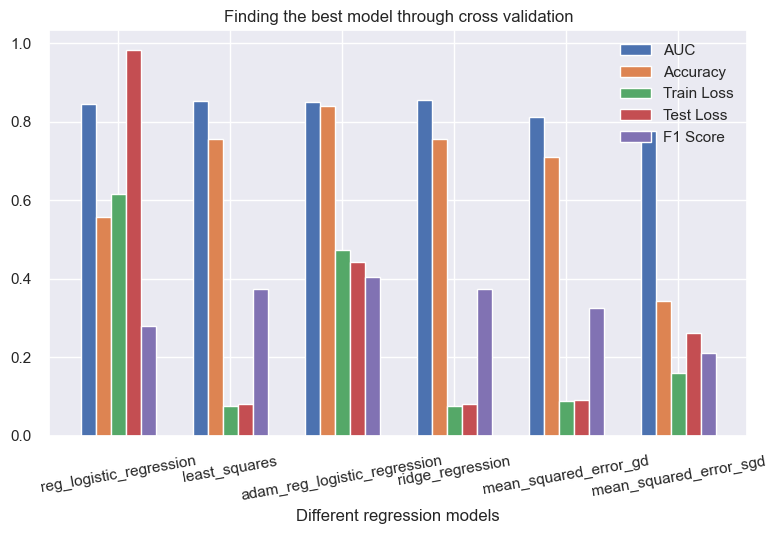

In [ ]:
AUC = []
accuracy = []
loss_tr = []
loss_te = []
F1 = []

for result in results_1:
    AUC.append(result['AUC'])
    accuracy.append(result['accuracy']/100)
    loss_tr.append(result['train_loss'])
    loss_te.append(result['test_loss'])
    F1.append(result["F1_score"])

num_bars = len(results_1)
w = 0.2  
pos = np.arange(num_bars) * 1.5  

plt.bar(pos - 2*w, AUC, width=w, label='AUC')
plt.bar(pos - w, accuracy, width=w, label='Accuracy')
plt.bar(pos, loss_tr, width=w, label='Train Loss')
plt.bar(pos + w, loss_te, width=w, label='Test Loss')
plt.bar(pos + 2*w, F1, width=w, label='F1 Score')  

plt.xticks(pos, methods, rotation=10)
plt.xlabel('Different regression models')
plt.title('Finding the best model through cross validation')
plt.legend()
plt.tight_layout()
plt.show()


### Precision-recall curve and F1 vs threshold curve

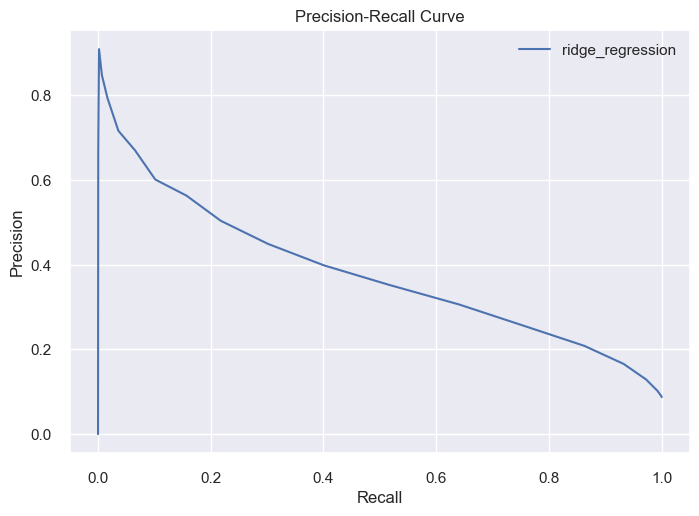

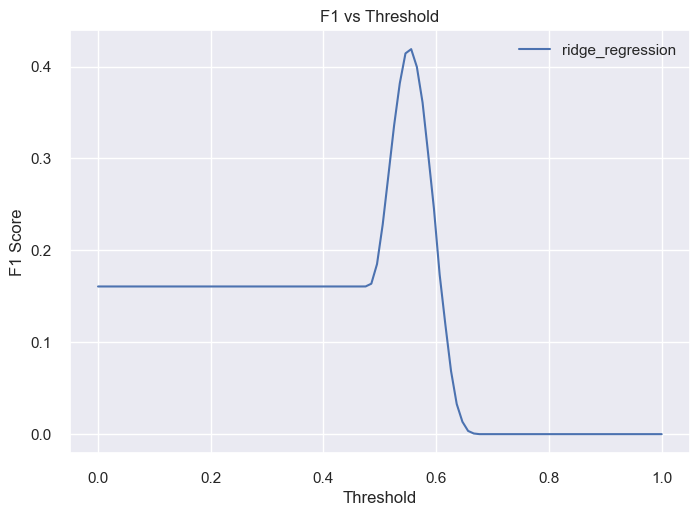

In [35]:
def plot_precision_recall(y_true, y_score, method):
    thresholds = np.linspace(0, 1, 100)
    precision, recall = [], []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        p = tp / (tp + fp + 1e-9)
        r = tp / (tp + fn + 1e-9)
        precision.append(p)
        recall.append(r)

    plt.plot(recall, precision, label=f"{method}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_f1_vs_threshold(y_true, y_score, method):
    thresholds = np.linspace(0, 1, 100)
    F1s = [compute_F1(y_true, (y_score >= t).astype(int)) for t in thresholds]
    plt.plot(thresholds, F1s, label=f"{method}")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot precision-recall curve
w_opt, _ = ridge_regression(y_val_split, x_val_split, 0.0004993 ) # use best lambda found through k-cross validation
y_score = sigmoid(x_val_split @ w_opt) 
plot_precision_recall(y_val_split, y_score, "ridge_regression")

# Plot F1 score vs threshold
plot_f1_vs_threshold(y_val_split, y_score, "ridge_regression")


### Test the model and generate the predictions

In [36]:
Xtest = np.genfromtxt("data/dataset/X_test_preprocessed.csv", delimiter=",", skip_header=1)
test_ids = Xtest[:, 0].astype(int)
print(f"Test IDs: {test_ids[:10]}")

Test IDs: [0 0 0 0 0 0 0 0 0 0]


In [54]:
import numpy as np
from helpers import create_csv_submission

# Define the prediction function 
def predict(method, X, w_opt, best_threshold):
    """
    Predict using the optimal weights from ridge regression.
    Threshold at 0.5 for binary classification (0 -> -1, 1 -> 1).
    """
    if method == "ridge_regression" :
    # Ridge regression is linear: we use X @ w_opt (dot product)
        y_score = X @ w_opt  # Compute the raw predictions
    elif method == "adam_reg_logistic_regression":
        y_score = sigmoid(X @ w_opt)

    # Apply the threshold to get the final prediction
    y_pred = (y_score >= best_threshold).astype(int)
    y_pred[y_pred == 0] = -1  # Convert 0s to -1 for AIcrowd submission format
    return y_pred

def generate_submission(method, w_opt, X_test_final, best_threshold,  test_ids, out_csv="submission.csv"):
    """
    Generate the submission file using the preprocessed X_test_final and ridge model's optimal weights (w_opt).
    """
    # Generate predictions on X_test_final using w_opt 
    y_pred = predict(method, X_test_final, w_opt, best_threshold)

    # Save the predictions in AIcrowd format
    create_csv_submission(test_ids, y_pred, out_csv)
    print(f"Saved {out_csv} | n={len(y_pred)} | {method} | dims={X_test_final.shape[1]}")

# ---- Load preprocessed X_test_final and test IDs ----
X_test_final = np.genfromtxt("data/dataset/X_test_preprocessed.csv", delimiter=",", skip_header=1)  # preprocessed test data (already in PCA space)
X_test_raw = np.genfromtxt("data/dataset/x_test.csv", delimiter=",", skip_header=1)
test_ids = X_test_raw[:, 0].astype(int)  # the first column is the ID

w_opt_ridge, _ = ridge_regression(y_val_split, x_val_split, best_lambda_ridge)
#w_opt_adam, _ = reg_logistic_regression_adam(y_val_split, x_val_split, 0.000148516, w_initial, 200, 0.9, 0.999,  0.020932, 700 )

# ---- Call the submission function with the optimal weights ----
generate_submission("ridge_regression", w_opt_ridge, X_test_final,best_threshold_ridge, test_ids,  "submission_ridge.csv")
#generate_submission("adam_reg_logistic_regression", w_opt_adam, X_test_final,  best_threshold_adam,test_ids,  "submission_adam.csv")

Saved submission_ridge.csv | n=109379 | ridge_regression | dims=439
